# Monitoring Wetlands in Africa

* **Products used:**
[usgs_ls8c_level2_2](), 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[ga_ls8c_fractional_cover_2]()

> **Note:** This notebook can only be run on the Admin Sandbox as it uses USGS C2 provisonal data that is not yet ready for public release.

### Background

According to [Wetlands International](https://africa.wetlands.org/en/wetlands/what-are-wetlands/), Africa’s wetlands ecosystems are estimated to cover 131 million hectares, and include some of the most productive and biodiverse ecosystems in the world. They provide a host of ecosystem services that contribute to human well-being through nutrition, water supply and purification, climate and flood regulation, coastal protection, feeding and nesting sites for animals, recreational opportunities and increasingly, tourism.  As such, the health of wetland ecosystems has been identified as an important metric for the `Sustainable Development Goals` ([6.6.1 Change in the extent of water-related ecosystems over time](https://www.sdg6monitoring.org/indicator-661/)). 

The `Wetlands Insight Tool (WIT)` provides at a glance insights into a wetland's dynamics. The WIT is a spatiotemporal summary of an wetland that combines multiple datasets derived from the African Landsat archive held within DE Africa. `Fractional cover`, `WOfS`, and `surface reflectance` data are retrieved from DE Africa and combined to produce a stack plot describing the percentage of a wetland polygon as vegetation fractional cover, open water, and wet vegetation through time.  

> `Detailed Explanation:`
Data is retrieved for timesteps containing more than 80% cloud-free data (you can adjust this number in the code below). The code calculates the Tasselled-Cap Wetness (TCW, or just 'wetness') from surface reflectance and takes the maximum Fractional cover fraction per pixel, masking Fractional cover with TCW, and masking TCW with open water. For each pixel inside or overlapping the polygon describing the wetland, WIT calculates the dominant fractional cover type. WIT selects the largest percentage value for each pixel as the dominant fractional cover type. Fractional cover was masked using WOfS and TCW to remove areas of water and wet vegetation from areas where fractional cover is calculated. This is necessary as the fractional cover algorithm erroneously classifies water as green vegetation (PV). The resulting output is a stacked plot of open water, wet vegetation, photosynthetic vegetation, non-photosynthetic vegetation, and bare soil for the wetland polygon through time.

### Description
This notebook will run the Wetlands Insight Tool for the area encompassed by a polygon. This notebook uses a default shapefile that provides an example wetland for running the analysis. The polygons in this shapefile were hand drawn from a basemap, and they are only provided for demonstration purposes, they are not meant to represent the true delineation of any specific wetland.

1.  Load in a shapefile
2.  Select an individual polygon from the shapefile
3.  Run the Wetlands Insight Tool
4.  Plot the results as a stacked line plot
5.  Create a true colour animation of the wetland alongside the stack plot

<!-- 6.  Use the WIT tool to create a per-pixel classification of the wetland -->
<!-- 7.  Generate a second animation comparing the per-pixel classification to the true colour timeseries -->


> **Note: This analysis unavoidably uses a lot of memory, and thus it cannot be conducted over large areas and for long time-series. If you experience `kernel restarting` problems, consider reducing the length of the time-series, and/or reducing the spatial extent of the analysis**

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different polygon or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

***

### Load packages

In [1]:
import datacube
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image
from datacube.utils import geometry

from wetlands import animated_timeseries_WIT, WIT_drill

from deafrica_tools.datahandling import mostcommon_crs, load_ard
from deafrica_tools.plotting import map_shapefile
%load_ext autoreload
%autoreload 2 

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


## Analysis parameters

The following cell sets important parameters for the analysis:

* `shp_path`: a location path to the shapefile (e.g. `folder/input.shp`). 

* `time_range`: The date range to analyse (e.g. `('2015', '2019') `)

In [6]:
shp_path = '../Supplementary_data/Wetlands_insight_tool/WIT_example_polygons.shp'

time_range = ('2015-01' , '2019-12')


### Load shapefile

We will also ensure the polygon is in WGS84 coordinates (`epsg=4326`) using the `to_crs()` method to make sure it can index the datacube correctly.

In [7]:
gdf = gpd.read_file(shp_path).to_crs('epsg:4326') 
gdf

,Name,geometry
0,Lake_Fitri,"POLYGON ((17.48823 12.98059, 17.58475 12.88522..."
1,Lac_de_Korienze,"POLYGON ((-3.76755 15.38105, -3.74466 15.32864..."


### Select an individual polygon

We can do this by specifying the name of the polygon we want to interrogate using the parameter in the cell below, `wetland_name`.

The last part of this cell will plot the polygon over a basemap using the `deafrica_plotting` function `map_shapefile`

In [8]:
wetland_name = 'Lac_de_Korienze'

#index the gdf by the wetland name
poly = gdf[gdf.Name == wetland_name]
poly


,Name,geometry
1,Lac_de_Korienze,"POLYGON ((-3.76755 15.38105, -3.74466 15.32864..."


In [ ]:
#plot the shapefile over a basemap
map_shapefile(poly, 'Name', fillOpacity=0.1)

### Run the Wetlands Insight Tool

Even for small areas, this code can take a long time to run so you will need to be patient. This is because the tool loads three seperate datasets (Landsat SR, Fractional Cover, and WOfS), and calculates a tasselled cap index on the fly. 

In [ ]:
wetlands_df = WIT_drill(gdf=poly,
                        time=time_range,
                        min_gooddata=0.80,
                        TCW_threshold=-0.035,
                        export_csv=wetland_name+'_WIT.csv',
                        verbose=False
                       )
wetlands_df.head()


## Plot the results

If you would like to export the plot as a .png file, then set the variable below to `True`, and give the plot a `name` (e.g. the wetland's name)

In [14]:
export_plot = True
name = 'Lac_de_Korienze'

In [2]:
df = pd.read_csv('Lac_de_Korienze_WIT.csv')
df

,Datetime,wofs_area_percent,wet_percent,green_veg_percent,dry_veg_percent,bare_soil_percent
0,2015-01-08 10:36:11.651520,38.58,3.32,0.25,36.82,21.02
1,2015-01-16 10:37:38.956071,38.10,4.30,0.05,35.85,21.69
2,2015-01-24 10:36:13.481003,35.58,4.10,0.03,42.01,18.29
3,2015-02-01 10:37:34.789335,36.20,5.10,0.29,33.77,24.64
4,2015-02-09 10:36:19.331672,36.98,2.48,0.08,36.68,23.78
...,...,...,...,...,...,...
169,2019-11-27 10:37:57.030906,40.36,26.83,18.26,3.40,11.14
170,2019-12-05 10:19:53.267247,48.79,14.82,21.20,3.14,12.06
171,2019-12-13 10:37:55.860191,60.96,-0.78,22.64,5.18,12.01
172,2019-12-21 10:19:04.811039,45.50,7.89,21.72,9.12,15.76


<ipython-input-3-d89f566415dd>:31: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  plt.axis(xmin = df.index[0], xmax = df.index[-1], ymin = 0, ymax = 100, fontsize=fontsize)


NameError: name 'export_plot' is not defined

<Figure size 432x288 with 0 Axes>

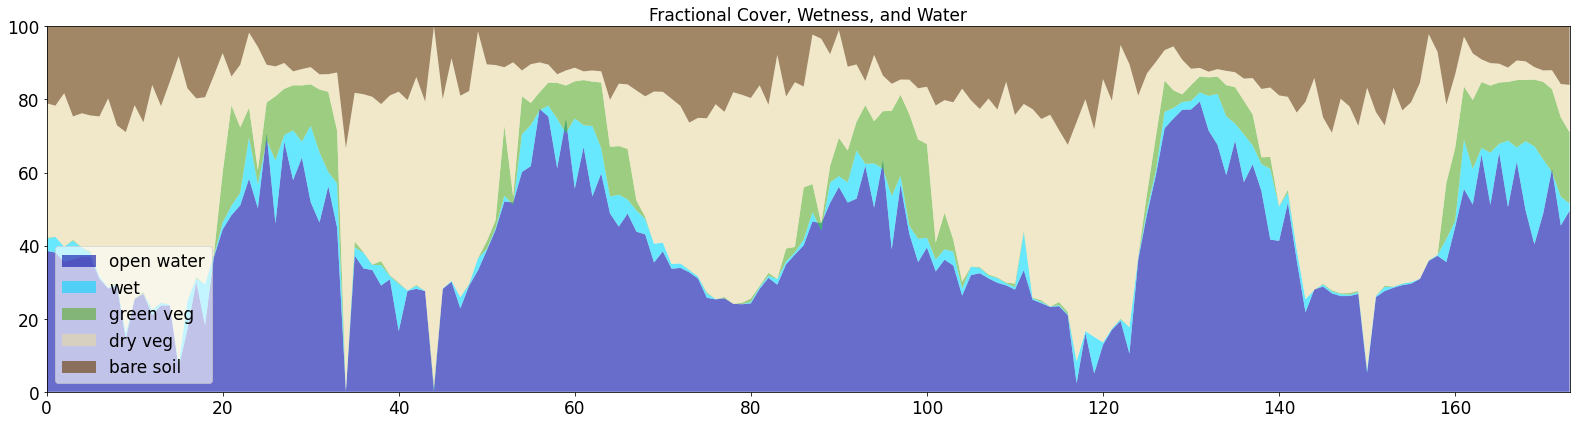

In [3]:
# df = wetlands_df

fontsize = 17

# generate plot

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

#make a stacked area plot
plt.clf()
fig=plt.figure(figsize = (22,6))
plt.stackplot(df.index, 
              df.wofs_area_percent, 
              df.wet_percent, 
              df.green_veg_percent, 
              df.dry_veg_percent,
              df.bare_soil_percent,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)

#set axis limits to the min and max
plt.axis(xmin = df.index[0], xmax = df.index[-1], ymin = 0, ymax = 100, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6, fontsize=fontsize)
plt.title('Fractional Cover, Wetness, and Water', fontsize=fontsize)
plt.tight_layout()
if export_plot:
    #save the figure
    plt.savefig(f'{name}_WIT.png')


***

## Animating the wetland timeseries

Using clear satellite observations over the wetland, we can animate a true-colour satellite images alongside an animation of the WIT stack plot.  This can help us visualise how the wetland has changed over time.

### Set up the datacube query

In [4]:
dc = datacube.Datacube(app='rgb_animation')

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

In [11]:
# Create a query object from the same polygon
# we used for the WIT drill
geom = geometry.Geometry(
        poly.geometry.values[0].__geo_interface__,
        geometry.CRS(
            "epsg:4326")
    )

query = {
    'geopolygon': geom,
    'time': time_range,
    'resolution': (-30,30),
    'group_by': 'solar_day'
}


### Load USGS Landsat data

In [12]:
#Load clear USGS C2 data
col2 = load_ard(dc=dc,
                min_gooddata=0.8,# this number must match WIT_drill
                products=["ls8_sr", "ls7_sr", "ls5_sr"],
                output_crs='epsg:6933',
                measurements=['red', 'green', 'blue'],
                **query)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls7_sr
    ls5_sr
Counting good quality pixels for each time step
Filtering to 174 out of 218 time steps with at least 80.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 174 time steps


### Animate true-colour and WIT plot

To smooth the timeseries and make a cleaner animation, we take the rolling mean of the time-series. 

The function `animated_timeseries_WIT` has been adapted from the code in `Scripts/deafrica_plotting` to work specifically with the WIT tool, however, many of the parameters are the same.  See the [animation notebook]() for more details on adjusting this plot.

    Exporting animation to Lac_de_Korienze_WIT.gif


Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/env/lib/python3.8/site-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/env/lib/python3.8/site-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/env/lib/python3.8/site-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "/home/jovyan/git/deafrica-sandbox-notebooks/Real_world_examples/wetlands.py", line 622, in update_figure
    df1.index
  File "/env/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 140, in cmp_method
    result = op(self._values, np.asarray(other))
TypeError: '<=' not supported between instances of 'int' and 'datetime.datetime'


TypeError: 'MovieWriterRegistry' object is not an iterator

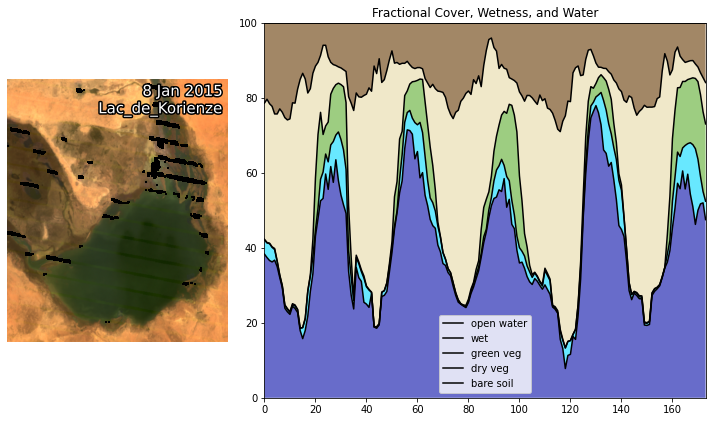

In [15]:
animated_timeseries_WIT(
    col2.rolling(time=3, center=True, min_periods=1).mean(),
    df.rolling(window=3, center=True, min_periods=1).mean(),
    name + "_WIT.gif",
    width_pixels=1000,
    interval=300,
    show_date=True,
    annotation_kwargs={'fontsize': 15},
    title=name,
)

# Plot animated gif
plt.close()
Image(filename=name + "_WIT.gif")

## Next steps
When you are done, you can return to the "Analysis Parameters" section and try inputing your own shapefile that defines the extent of a wetland of interest.

If you're going to change the location, you can check the availability of data using the [DE Africa Explorer](https://explorer.digitalearth.africa/ga_ls8c_gm_2_annual).

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Feb 2020

**Compatible `datacube` version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()